Importing Necessary Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

2023-04-11 00:37:03.692759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading the Datasets

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

train = pd.read_csv(r'/home/Intro_AI/Project/input/sign_mnist_train.csv')
test = pd.read_csv(r'/home/Intro_AI/Project/input/sign_mnist_test.csv')

print('Number of training samples:', len(train))
print('Number of testing samples:', len(test))

Number of training samples: 27455
Number of testing samples: 7172


Ensure we are correctly loading the labeled dataset

In [6]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [7]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


Show the Distribution of The training and test Datasets

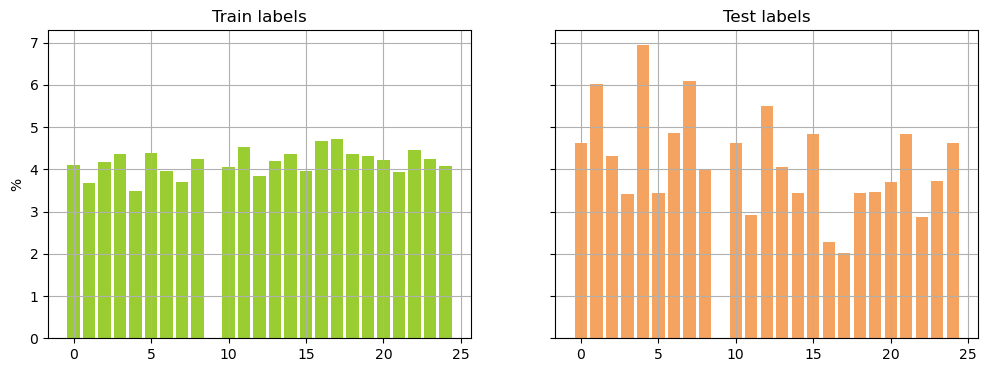

Number of image pixel: 784
Quadratic image size: 28
Number of labels: 24


In [8]:
labels = list(train['label'].value_counts().keys().sort_values())

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    
axs[0].bar(labels, 100*train['label'].value_counts().sort_index().values/len(train), color='yellowgreen')
axs[1].bar(labels, 100*test['label'].value_counts().sort_index().values/len(test), color='sandybrown')
axs[0].grid()
axs[1].grid()
axs[0].set_title('Train labels')
axs[1].set_title('Test labels')
axs[0].set_ylabel('%')
plt.show()

print('Number of image pixel:', len(train.columns[1:]))
print('Quadratic image size:', int(np.sqrt(len(train.columns[1:]))))
print('Number of labels:', len(labels))

Shape and Categorize Data for NN input

In [9]:
# Selects all the columns of the train_data DataFrame except for the label for train and test datasets
X_train = train[train.columns[1:]]
X_test = test[test.columns[1:]]

# Converts the values DataFrame to a numpy array, reshapes it into a 4D tensor with dimensions (-1, 28, 28, 1).
#  "-1"  means the size of the first dimension will be inferred automatically. The others represent the 
# h,w, and color channel, "1" meaning greyscale
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

# selects the column with the label data
y_train = train['label']
y_test = test['label']

# one-hot encodes the labels using Keras.
y_train = to_categorical(y_train, num_classes = 25)
y_test = to_categorical(y_test, num_classes = 25)

 Displays dataframes from the training set with their labels

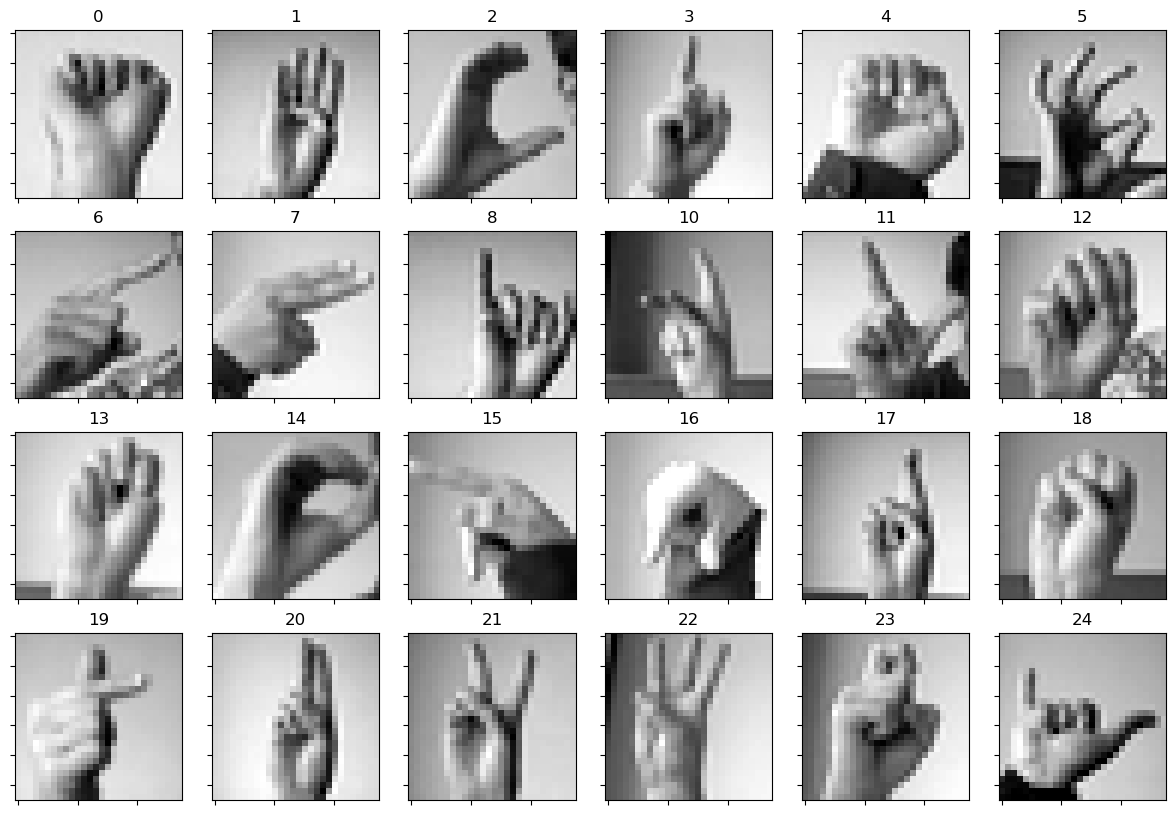

In [10]:
fig, axs = plt.subplots(4, 6, figsize=(15, 10))
fig.subplots_adjust(hspace = 0.2, wspace=.1)
axs = axs.ravel()
for i in range(24):
    idx = train[train['label']==labels[i]].index[0]
    axs[i].imshow(X_train[idx][:,:,0], cmap='gray')

    axs[i].set_title(y_train[idx].argmax())
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

Scale Data

In [11]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

Define and train Model

In [12]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
#model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))  #
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))   #
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
#model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))  #
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))   #
model.add(Flatten())
#model.add(Dense(256, activation = "relu")) #
model.add(Dropout(0.5))

model.add(Dense(25, activation = "softmax"))

optimizer = RMSprop(lr=0.001,rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


epochs = 5
batch_size = 64

model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_data= (X_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

2023-04-11 00:37:11.110869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 00:37:11.111394: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/root/miniconda3/envs/cs4795/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5
429/429 [==============================] - 38s 87ms/step - loss: 1.6628 - accuracy: 0.4989 - val_loss: 0.7384 - val_accuracy: 0.7695
Epoch 2/5
429/429 [==============================] - 33s 76ms/step - loss: 0.4589 - accuracy: 0.8479 - val_loss: 0.4429 - val_accuracy: 0.8588
Epoch 3/5
429/429 [==============================] - 27s 62ms/step - loss: 0.2158 - accuracy: 0.9276 - val_loss: 0.3408 - val_accuracy: 0.9057
Epoch 4/5
429/429 [==============================] - 40s 94ms/step - loss: 0.1222 - accuracy: 0.9590 - val_loss: 0.3210 - val_accuracy: 0.9226
Epoch 5/5
429/429 [==============================] - 38s 88ms/step - loss: 0.0834 - accuracy: 0.9720 - val_loss: 0.3234 - val_accuracy: 0.9189


Run Predictions on the validation set

225/225 [==============================] - 2s 7ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0.]
19
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
15
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0.]
20
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0.]
18
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
2
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
1


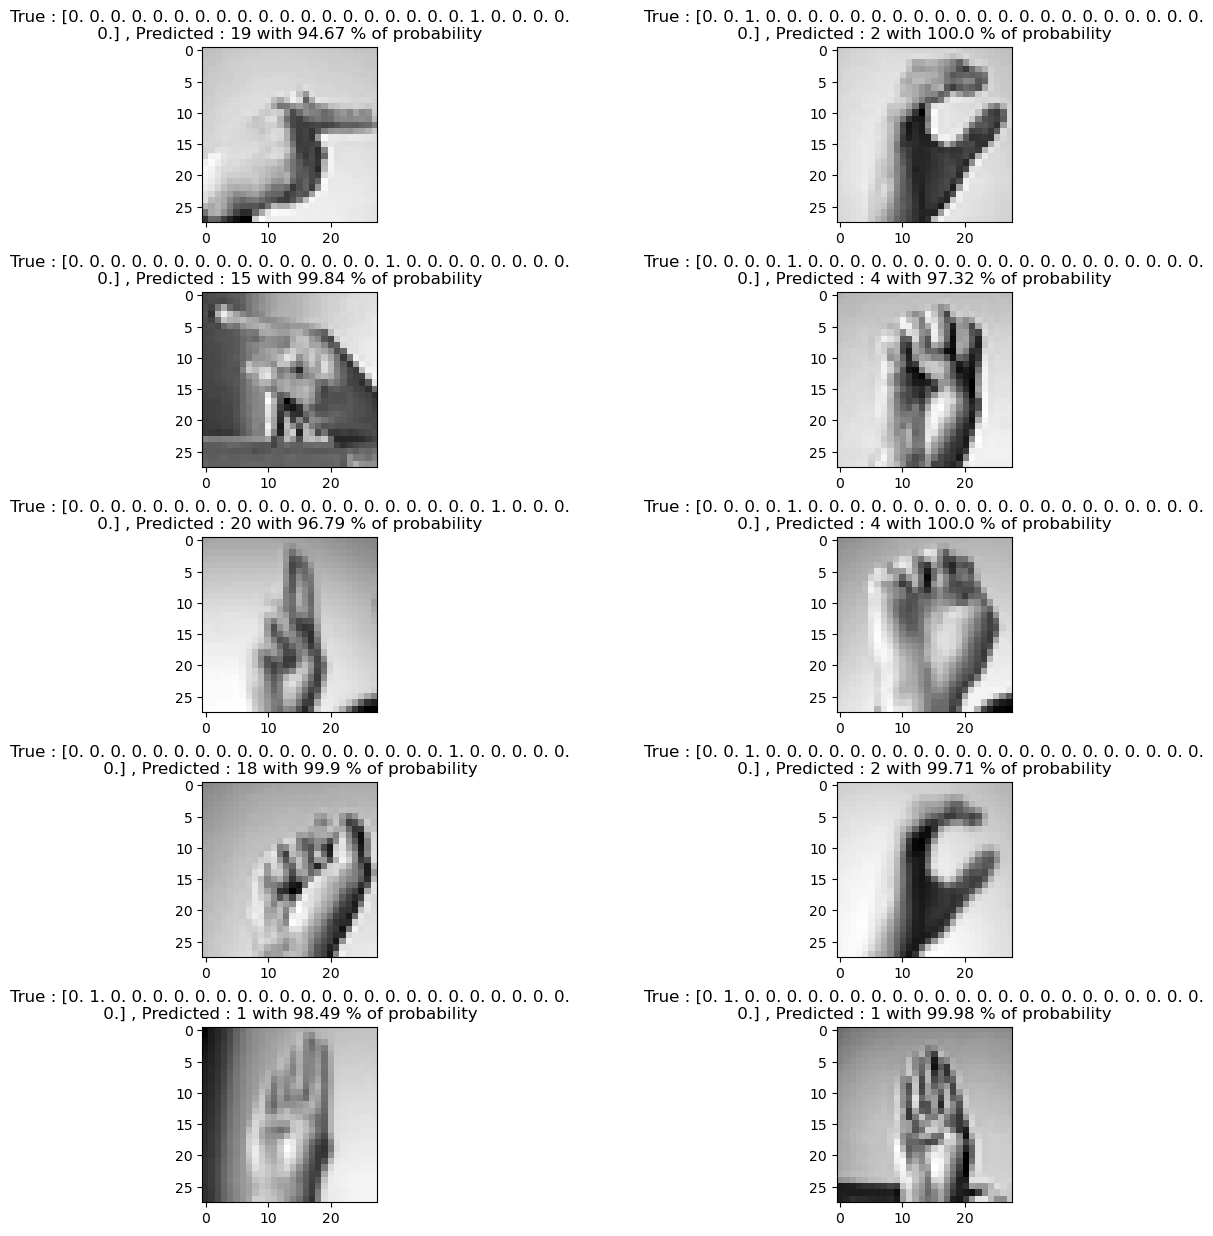

In [13]:
# uses the trained model to predict the class labels for the test data
y_pred = model.predict(X_test)

# convert the predicted and actual class labels into one-dimensional arrays of integers. 
# returns the index of the maximum value in the input array, which in this case corresponds to the predicted or actual class label.
y_pred2 = np.array([np.argmax(y_pred[i]) for i in range(len(y_pred))])
y_test2 = np.array([np.argmax(y_test[i]) for i in range(len(y_test))])

letters = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','undef']

# generates a plot of ten randomly selected test images, along with the true and predicted labels
plt.figure(figsize = (15,15))
for i in range(10):
  ind = np.random.randint(0,len(X_test))
  print(y_test[ind])
  print(y_pred2[ind])
  plt.subplot(5,2,i+1)
  plt.imshow(X_test[ind].reshape(28,28),cmap = 'gray')
  plt.title('True : {} , Predicted : {} with {} % of probability '.format(y_test[ind],
                                                                            y_pred2[ind],
                                                                            round(y_pred[ind][y_pred2[ind]]*100,2)
                                                                            ))
plt.subplots_adjust(hspace=0.4)
plt.show()

Loading an image of our own to classify

In [15]:
# example of converting an image with the Keras API
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import array_to_img

# load the image
img = load_img(r'/home/Intro_AI/Project/input/e1.jpg',target_size=(28, 28))
img = img.resize([28,28])
print(type(img))

# convert to numpy array
img_array = img_to_array(img)
#np.expand_dims(img_array,axis=0)
#img_array = img_array.reshape(28, 28)
print(img_array.dtype)
print(img_array.shape)


# convert back to image
#img_pil = array_to_img(img_array)
print(type(img))

img = np.expand_dims(img, axis=0)
model.predict(img)

<class 'PIL.Image.Image'>
float32
(28, 28, 3)
<class 'PIL.Image.Image'>


ValueError: in user code:

    File "/root/miniconda3/envs/cs4795/lib/python3.10/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/root/miniconda3/envs/cs4795/lib/python3.10/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/root/miniconda3/envs/cs4795/lib/python3.10/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/root/miniconda3/envs/cs4795/lib/python3.10/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/root/miniconda3/envs/cs4795/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/root/miniconda3/envs/cs4795/lib/python3.10/site-packages/keras/engine/input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential" "                 f"(type Sequential).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 28, 28, 3)
    
    Call arguments received by layer "sequential" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 28, 28, 3), dtype=uint8)
      • training=False
      • mask=None


In [ ]:
#plt.imshow(img_array[:,:,0], cmap = 'gray')